## Download and install

In [ ]:
!git clone https://github.com/dhansmair/flamingo-mini.git
!pip install ./flamingo-mini
!pip install datasets transformers[sentencepiece]

fatal: destination path 'flamingo-mini' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./flamingo-mini
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for flamingo-mini: filename=flamingo_mini-0.0.2-py3-none-any.whl size=18531 sha256=07f6da9c130152111276408486b569e8065c2dc2188beff722c6f784615ccee0
  Stored in directory: /root/.cache/pip/wheels/c3/b5/eb/81a06fac568b8933e66216e136fb5383f1fa45187d51df56da
Successfully built flamingo-mini
  Attempting uninstall: flamingo-mini
    Found existing installation: flamingo-mini 0.0

In [ ]:
import torch
import numpy as np

from flamingo_mini import FlamingoModel, FlamingoConfig, FlamingoProcessor
from flamingo_mini.utils import load_url
from einops import repeat
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor 
from datasets import load_dataset
from matplotlib import pyplot as plt

## Model

### CLIP vision encoder + GPT2

In [ ]:
device = torch.device('cuda')

# This model was not trained for few-shot
model = FlamingoModel.from_pretrained('dhansmair/flamingo-tiny')
model.to(device)
model.eval()

processor = FlamingoProcessor(model.config, device=device, load_vision_model=True)

## Few-Shot

### Посмотрим как работает Few-Shot

In [ ]:
def multimodal_prompt_inner(model, processor, prompt, images, device) -> str:
    input_ids, media_locations, attention_mask = processor.encode_text(prompt, device=device)
    visual_features = processor.extract_features(images)
    
    output = model.generate(
        inputs=input_ids,
        media_locations=media_locations,
        attention_mask=attention_mask,
        visual_features=repeat(visual_features, 'N v d -> b N T v d', b=1, T=1),           
        max_length=150,
        use_cache=True,
        early_stopping=True,
        bos_token_id=model.flamingo.lm.config.bos_token_id,
        eos_token_id=model.flamingo.lm.config.eos_token_id,
        pad_token_id=model.flamingo.lm.config.eos_token_id
    )

    response = processor.tokenizer.batch_decode(output, skip_special_tokens=True)
    return response[0]

In [ ]:
def multimodal_prompt(model, processor, prompt, images, device, verbose=True):
    if verbose:
        print(f'Prompt: {prompt}')
    response = multimodal_prompt_inner(
        model=model,
        processor=processor,
        prompt=prompt,
        images=images,
        device=device
    )
    if verbose:
        print(f'Ouput: {response}')

In [ ]:
def display_images(*images, size=(20, 20)):
    fig, axs = plt.subplots(ncols=len(images), figsize=size)
    if len(images) == 1:
        axs.imshow(images[0])
        axs.set_axis_off()
    else:
        for i, pic in enumerate(images):
            axs[i].imshow(pic)
            axs[i].set_axis_off()

In [ ]:
cat_url = "https://img.freepik.com/premium-photo/gray-scottish-cat-is-lying-by-window-cat-is-wearing-green-sunglasses_650650-3159.jpg"
elephants_url = "https://cdn-ccbam.nitrocdn.com/ychWYWPbawiVjyShkPeowOjrCDAYzDmS/assets/static/optimized/rev-725e39e/wp-content/uploads/2019/07/iStock-184652578-1-300x200-1.jpg"
flamingo_url = "https://www.byte.fm/media/broadcasts/vicko-mozara-m82uh_vamhg-unsplash.jpg.600x500_q85_box-0%2C742%2C2983%2C3228_crop_detail.jpg"

cat_image = load_url(cat_url)
elephants_image = load_url(elephants_url)
flamingo_image = load_url(flamingo_url)

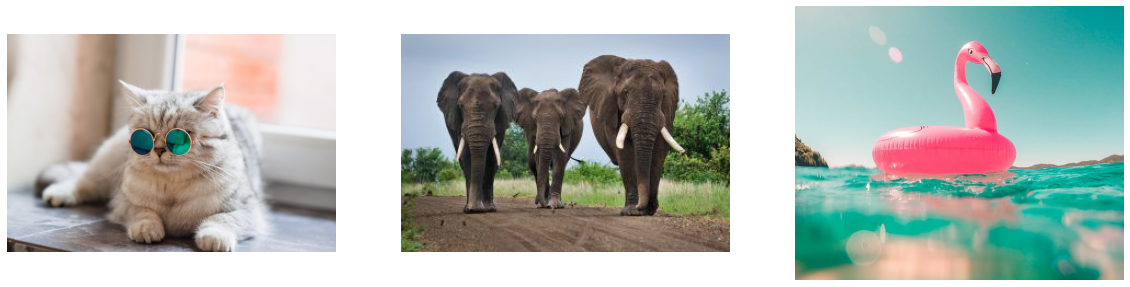

In [ ]:
display_images(cat_image, elephants_image, flamingo_image, size=(20, 20))

In [ ]:
prompt = "<image> picture of a cat <EOC> <image> picture of elephants <EOC> <image> picture of"
multimodal_prompt(model, processor, prompt, images=[cat_image, elephants_image, flamingo_image], device=device)

Prompt: <image> picture of a cat <EOC> <image> picture of elephants <EOC> <image> picture of
Ouput: <image> picture of a cat <EOC> <image> picture of elephants <EOC> <image> picture of a flamingo <EOC>


### Adding details

In [ ]:
prompt = "<image> picture of a grey cat <EOC> <image> picture of brown elephants <EOC> <image> picture of"
multimodal_prompt(model, processor, prompt, images=[cat_image, elephants_image, flamingo_image], device=device)

Prompt: <image> picture of a grey cat <EOC> <image> picture of brown elephants <EOC> <image> picture of
Ouput: <image> picture of a grey cat <EOC> <image> picture of brown elephants <EOC> <image> picture of pink flamingo <EOC>


### Doesn't always work

Counting animals

In [ ]:
prompt = "<image> picture of 1 cat <EOC> <image> picture of 3 elephants <EOC> <image> picture of"
multimodal_prompt(model, processor, prompt, images=[cat_image, elephants_image, flamingo_image], device=device)

Prompt: <image> picture of 1 cat <EOC> <image> picture of 3 elephants <EOC> <image> picture of
Ouput: <image> picture of 1 cat <EOC> <image> picture of 3 elephants <EOC> <image> picture of a flamingo <EOC>


Location

In [ ]:
prompt = "<image> picture of cat on the windowsill <EOC> <image> picture of elephants on the ground <EOC> <image> picture of"
multimodal_prompt(model, processor, prompt, images=[cat_image, elephants_image, flamingo_image], device=device)

Prompt: <image> picture of cat on the windowsill <EOC> <image> picture of elephants on the ground <EOC> <image> picture of
Ouput: <image> picture of cat on the windowsill <EOC> <image> picture of elephants on the ground <EOC> <image> picture of a flamingo <EOC>


Abstract description

In [ ]:
prompt = "<image> picture of a small animal <EOC> <image> picture of big animals <EOC> <image> picture of"
multimodal_prompt(model, processor, prompt, images=[cat_image, elephants_image, flamingo_image], device=device)

Prompt: <image> picture of a small animal <EOC> <image> picture of big animals <EOC> <image> picture of
Ouput: <image> picture of a small animal <EOC> <image> picture of big animals <EOC> <image> picture of pink flamingo <EOC>


[Conceptual Captions](https://huggingface.co/datasets/conceptual_captions) dataset is used for learning

### Let's try the real flamingo

In [ ]:
flamingo_real_url = "https://gkd.ru/assets/i/ai/4/4/1/i/2989504.jpg"
flamingo_real_image = load_url(flamingo_real_url)

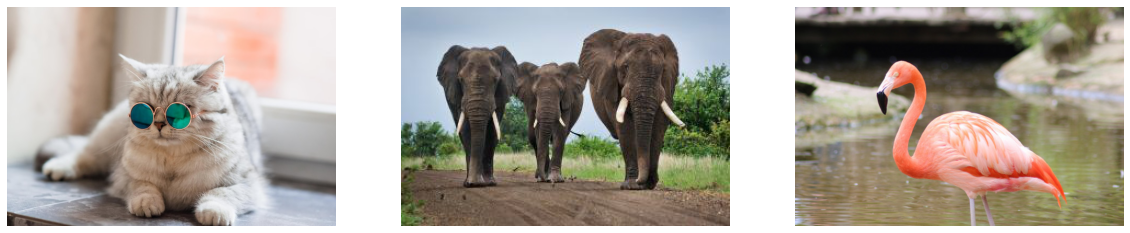

In [ ]:
display_images(cat_image, elephants_image, flamingo_real_image, size=(20, 20))

In [ ]:
prompt = "<image> picture of a cat <EOC> <image> picture of elephants <EOC> <image> picture of"
multimodal_prompt(model, processor, prompt, images=[cat_image, elephants_image, flamingo_real_image], device=device)

Prompt: <image> picture of a cat <EOC> <image> picture of elephants <EOC> <image> picture of
Ouput: <image> picture of a cat <EOC> <image> picture of elephants <EOC> <image> picture of animal <EOC>


Just an animal :(

In [ ]:
prompt = "<image> picture of a grey cat <EOC> <image> picture of brown elephants <EOC> <image> picture of"
multimodal_prompt(model, processor, prompt, images=[cat_image, elephants_image, flamingo_real_image], device=device)

Prompt: <image> picture of a grey cat <EOC> <image> picture of brown elephants <EOC> <image> picture of
Ouput: <image> picture of a grey cat <EOC> <image> picture of brown elephants <EOC> <image> picture of animal <EOC>


Still

In [ ]:
prompt = "<image> picture of a grey cat <EOC> <image> picture of brown elephants <EOC> <image> picture of pink"
multimodal_prompt(model, processor, prompt, images=[cat_image, elephants_image, flamingo_real_image], device=device)

Prompt: <image> picture of a grey cat <EOC> <image> picture of brown elephants <EOC> <image> picture of pink
Ouput: <image> picture of a grey cat <EOC> <image> picture of brown elephants <EOC> <image> picture of pink flamingo <EOC>


Works better after adding details

## Image captioning

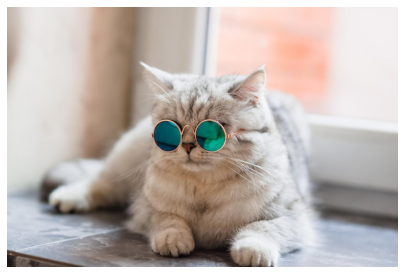

In [ ]:
display_images(cat_image, size=(7, 7))

In [ ]:
prompt = "<image> picture of"
multimodal_prompt(model, processor, prompt, images=[cat_image], device=device)

Prompt: <image> picture of
Ouput: <image> picture of cat wearing sunglasses sitting on the windowsill <EOC>


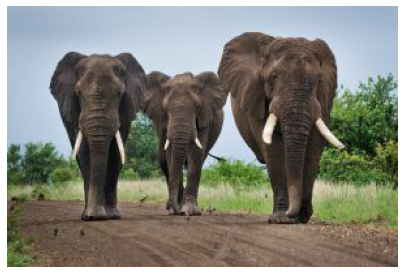

In [ ]:
display_images(elephants_image, size=(7, 7))

In [ ]:
prompt = "<image> picture of"
multimodal_prompt(model, processor, prompt, images=[elephants_image], device=device)

Prompt: <image> picture of
Ouput: <image> picture of elephants walking towards the camera <EOC>


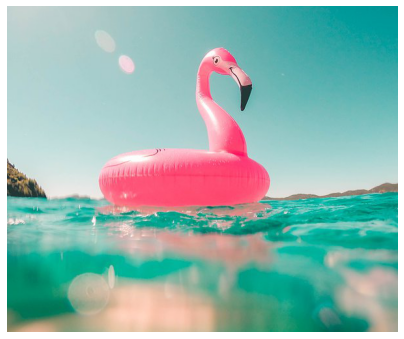

In [ ]:
display_images(flamingo_image, size=(7, 7))

In [ ]:
prompt = "<image> picture of"
multimodal_prompt(model, processor, prompt, images=[flamingo_image], device=device)

Prompt: <image> picture of
Ouput: <image> picture of a pink flamingo in the water <EOC>


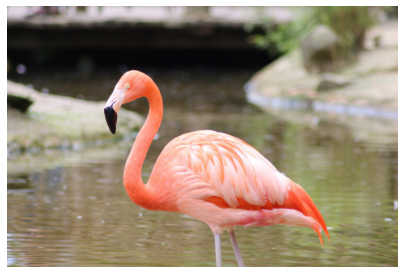

In [ ]:
display_images(flamingo_real_image, size=(7, 7))

In [ ]:
prompt = "<image> picture of"
multimodal_prompt(model, processor, prompt, images=[flamingo_real_image], device=device)

Prompt: <image> picture of
Ouput: <image> picture of animal in the wild - photo # <EOC>


In [ ]:
prompt = "<image> picture of pink"
multimodal_prompt(model, processor, prompt, images=[flamingo_real_image], device=device)

Prompt: <image> picture of pink
Ouput: <image> picture of pink flamingo in the wild - photo # <EOC>


## Zero-Shot classification

In [ ]:
def text_to_token(text):
    res = processor.tokenizer.encode(text)
    assert len(res) == 2
    return res[-1]

In [ ]:
def get_probs_prompt(model: FlamingoModel, processor: FlamingoProcessor, prompt: str, images: list, device: torch.device) -> str:
    input_ids, media_locations, attention_mask = processor.encode_text(prompt, device=device)
    visual_features = processor.extract_features(images)
    with torch.no_grad():
        model_inputs = model.prepare_inputs_for_generation(
            input_ids, past=None,
            attention_mask=attention_mask, use_cache=True,
            media_locations=media_locations,
            visual_features=repeat(visual_features, 'N v d -> b N T v d', b=1, T=1),
        )
        logits = model.forward(**model_inputs).logits.detach().cpu()
        probs = torch.softmax(logits[0, -1, :], dim=-1)
    return probs

In [ ]:
def calc_probs_classification(dataset, prompt, label_names, verbose=True):
    avg_probs = [[] for i in range(len(label_names))]
    avg_acc = [[] for i in range(len(label_names))]
    label_tokens = torch.Tensor([text_to_token(name) for name in label_names]).to(torch.long)
    ok = []
    for i, dct in enumerate(dataset):
        pic, label = dct['image'], dct['labels']
        response = get_probs_prompt(model, processor, prompt, images=[
            pic
        ], device=device)[label_tokens]
        ok.append(np.argmax(response) == label)
        avg_acc[label].append(np.argmax(response) == label)
        avg_probs[label].append(response[label])
    if verbose:
        avg_acc = [np.array(cur_acc).mean() for cur_acc in avg_acc]
        avg_probs = [np.array(cur_probs).mean() for cur_probs in avg_probs]
        for i, name in enumerate(label_names):
            print(f'Label {name}, average accuracy: {avg_acc[i]}')
        print(f'Accuracy {np.array(ok).mean()}')

### Cats and dogs dataset

In [ ]:
cats_dogs = load_dataset('cats_vs_dogs')
train_animals = cats_dogs['train'].shuffle(seed=42)

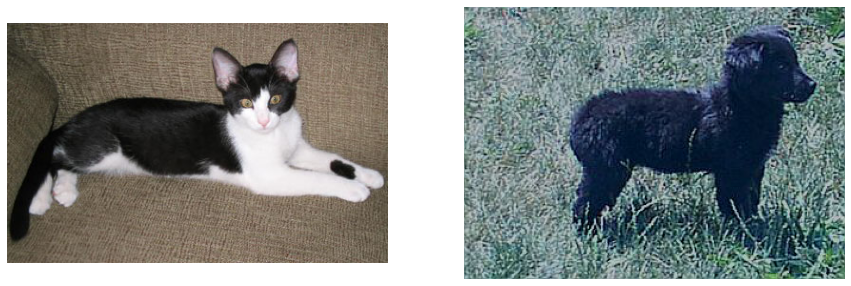

In [ ]:
display_images(train_animals[1]['image'], train_animals[0]['image'], size=(15, 15))

In [ ]:
calc_probs_classification(
    train_animals.select(range(500)), 
    '<image> picture of',
    ['cat', 'dog']
)

Label cat, average accuracy: 0.9959677419354839
Label dog, average accuracy: 1.0
Accuracy 0.998


Let's try a more specific prompt

In [ ]:
calc_probs_classification(
    train_animals.select(range(500)), 
    '<image> picture of a cute fluffy',
    ['cat', 'dog']
)

Label cat, average accuracy: 1.0
Label dog, average accuracy: 1.0
Accuracy 1.0


### MNIST dataset

In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.dataset[idx][0]
        label = self.dataset[idx][1]

        if self.transform is not None:
            image = self.transform(image)
        return {'image': image, 'labels': label}

In [ ]:
train_mnist = datasets.MNIST(
    root = 'mnist',
    train = True,                         
    transform = None, 
    download = True,            
)
mnist_dataset = MNISTDataset(train_mnist)
mnist_subset = torch.utils.data.Subset(mnist_dataset, np.random.randint(len(mnist_dataset), size=1000))

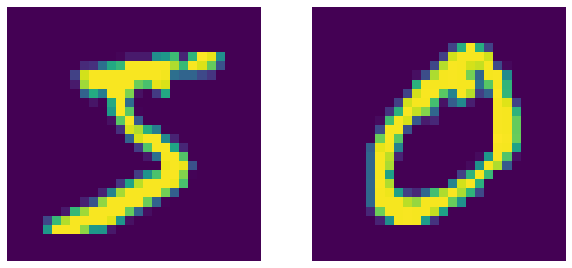

In [ ]:
display_images(mnist_dataset[0]['image'], mnist_dataset[1]['image'], size=(10, 10))

In [ ]:
calc_probs_classification(
    mnist_subset, 
    '<image> picture of digit',
    ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
)

Label zero, average accuracy: 0.8269230769230769
Label one, average accuracy: 0.02459016393442623
Label two, average accuracy: 0.5643564356435643
Label three, average accuracy: 0.0
Label four, average accuracy: 0.0
Label five, average accuracy: 0.024390243902439025
Label six, average accuracy: 0.0
Label seven, average accuracy: 0.0
Label eight, average accuracy: 0.0
Label nine, average accuracy: 0.0
Accuracy 0.148


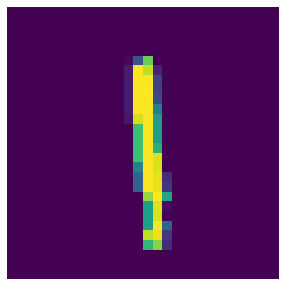

In [ ]:
display_images(mnist_dataset[8]['image'], size=(5, 5))

In [ ]:
prompt = "<image> picture of"
multimodal_prompt(model, processor, prompt, images=[mnist_dataset[8]['image']], device=device)

Prompt: <image> picture of
Ouput: <image> picture of a white line drawing with a black background <EOC>


Let's describe 0 and 1 in terms of shapes

In [ ]:
calc_probs_classification(
    mnist_subset, 
    '<image> picture of',
    ['circle', 'line', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
)

Label circle, average accuracy: 0.5192307692307693
Label line, average accuracy: 0.8770491803278688
Label two, average accuracy: 0.07920792079207921
Label three, average accuracy: 0.0
Label four, average accuracy: 0.06306306306306306
Label five, average accuracy: 0.25609756097560976
Label six, average accuracy: 0.020833333333333332
Label seven, average accuracy: 0.2978723404255319
Label eight, average accuracy: 0.022222222222222223
Label nine, average accuracy: 0.0
Accuracy 0.229
